In [75]:
import numpy as np
import pandas as pd
import random
from datetime import timedelta, datetime
import base64
import time


def generate_fake_sales_data(
    num_days=30,
    num_products=10,
    zero_sales_ratio=0.3,
    volume_level="medium",  # 'low', 'medium', 'high'
    categorical_choices=None,
    seasonality=30,
    start_date="2020-01-01",
    seed=None,
):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # Default categories
    if categorical_choices is None:
        categorical_choices = {
            "color": ["red", "blue", "green", "black", "white"],
            "size": ["S", "M", "L", "XL"],
            "category": ["shoes", "dress", "suit", "socks", "bag", "costume"],
            "subcategory": ["A", "B", "C", "D", "E", "F"],
        }

    # Volume map
    volume_map = {"low": (0, 5), "medium": (5, 20), "high": (20, 100)}
    min_sales, max_sales = volume_map[volume_level]

    # Parse start date
    start = datetime.strptime(start_date, "%Y-%m-%d")
    dates = [start + timedelta(days=i) for i in range(num_days)]

    data = []

    for _ in range(num_products):
        product_id = base64.standard_b64encode(f"{time.time()}".encode()).decode()
        product_cats = {
            k: random.choice(categorical_choices[k])
            for k in ["category", "subcategory"]
        }

        # Per-product seasonality phase/scale
        phase = random.uniform(0, 2 * np.pi)
        seasonal_amp = random.uniform(0.5, 1.5)
        price = round(np.random.uniform(5.0, 100.0), 2)

        for day_idx, date in enumerate(dates):
            # Seasonality component
            seasonal_factor = 1.0
            if seasonality:
                seasonal_factor += seasonal_amp * np.sin(
                    2 * np.pi * day_idx / seasonality + phase
                )

            if np.random.rand() < zero_sales_ratio:
                sales_qty = 0
            else:
                base_sales = np.random.randint(min_sales, max_sales + 1)
                sales_qty = int(base_sales * seasonal_factor)
                sales_qty = max(0, sales_qty)  # ensure non-negative

            # stock = np.random.randint(0, 1000)
            # discount = round(np.random.uniform(0.0, 0.3), 2)

            row = {
                "date": date,
                "product_id": product_id,
                "sales_qty": sales_qty,
                "price": price,
                # 'stock': stock,
                # 'discount': discount,
                **product_cats
                | {
                    k: random.choice(v)
                    for k, v in categorical_choices.items()
                    if k not in ["category", "subcategory"]
                },
            }
            data.append(row)

    return pd.DataFrame(data)


from sklearn.datasets import make_regression
import pandas as pd
import numpy as np
import random
from datetime import timedelta, datetime


def generate_sklearn_sales_data(
    num_days=30,
    num_products=10,
    zero_sales_ratio=0.2,
    volume_level="medium",  # 'low', 'medium', 'high'
    seasonality=False,
    start_date="2020-01-01",
    seed=42,
):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # Define volume scaling
    volume_scale = {"low": 5, "medium": 20, "high": 100}[volume_level]

    # Product categorical features
    categorical_choices = {
        "color": ["red", "blue", "green", "black", "white"],
        "size": ["S", "M", "L", "XL"],
        "category": ["shoes", "dress", "suit", "socks", "bag", "costume"],
        "subcategory": ["A", "B", "C", "D", "E", "F"],
    }

    start = datetime.strptime(start_date, "%Y-%m-%d")
    all_rows = []

    for _ in range(num_products):
        product_id = base64.standard_b64encode(f"{time.time()}".encode()).decode()
        product_cats = {
            k: random.choice(categorical_choices[k])
            for k in ["category", "subcategory"]
        }

        X, y = make_regression(n_samples=num_days, n_features=3, noise=0.2)
        price = np.clip(X[:, 0] * 10 + 50, 5, 150)
        stock = np.clip(X[:, 1] * 100 + 500, 0, 2000)
        discount = np.clip(np.abs(X[:, 2] * 0.05), 0, 0.3)

        for i in range(num_days):
            date = start + timedelta(days=i)

            # Seasonality
            seasonal_factor = 1.0
            if seasonality:
                seasonal_factor += np.sin(
                    2 * np.pi * i / seasonality + np.random.uniform(0, 2 * np.pi)
                )

            # Determine sales quantity
            if np.random.rand() < zero_sales_ratio:
                sales_qty = 0
            else:
                raw_sales = y[i] * seasonal_factor * 0.1
                sales_qty = int(np.clip(abs(raw_sales), 0, None) * volume_scale)

            row = {
                "date": date,
                "product_id": product_id,
                "sales_qty": sales_qty,
                "price": round(price[i], 2),
                "stock": int(stock[i]),
                "discount": round(discount[i], 2),
                **product_cats
                | {
                    k: random.choice(v)
                    for k, v in categorical_choices.items()
                    if k not in ["category", "subcategory"]
                },
            }
            all_rows.append(row)

    return pd.DataFrame(all_rows)


from tqdm.auto import tqdm

# Store-level demand multipliers
store_ids = [f"store_{i}" for i in range(20)]
store_factors = {sid: round(random.uniform(0.5, 2.0), 2) for sid in store_ids}
MAX_PRODUCTS = 100
seasonalities = {
    pid: random.choice([False, 30, 30 * 4, 30 * 8, 365]) for pid in range(MAX_PRODUCTS)
}
volumes = {pid: random.choice([5, 20, 100]) for pid in range(MAX_PRODUCTS)}
zero_sales_ratio = {
    pid: random.choice([round(0.1 * i, 1) for i in range(0, 10)])
    for pid in range(MAX_PRODUCTS)
}


def generate_sklearn_sales_data_v2(
    num_days=30,
    num_products=20,
    num_stores=5,
    start_date="2020-01-01",
    seed=None,
):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    if num_stores > len(store_ids):
        num_stores = len(store_ids)

    # Promo logic: 10% of days are promos
    def is_promo():
        return np.random.rand() < 0.1

    # volume_scale = {"low": 5, "medium": 20, "high": 100}[volume_level]

    start = datetime.strptime(start_date, "%Y-%m-%d")

    # Product categorical features
    categorical_choices = {
        "color": ["red", "blue", "green", "black", "white"],
        "size": ["S", "M", "L", "XL"],
        "category": ["shoes", "dress", "suit", "socks", "bag", "costume"],
        "subcategory": ["A", "B", "C", "D", "E", "F"],
    }
    # Example categorical behavior maps
    category_factor = {
        "shoes": 1.2,
        "dress": 1.4,
        "suit": 1.0,
        "socks": 0.8,
        "bag": 0.8,
        "costume": 0.5,
    }
    subcategory_factor = {"A": 1.2, "B": 1.5, "C": 1, "D": 0.8, "E": 0.6, "F": 0.7}
    size_factor = {"S": 0.8, "M": 1.0, "L": 1.1, "XL": 1.2}
    color_bias = {"red": 1.0, "blue": 1.0, "green": 0.95, "black": 1.05, "white": 1.0}

    all_rows = []

    for pid in tqdm(range(num_products)):
        # product_id = base64.standard_b64encode(f"{time.time()}".encode()).decode()
        product_id = f"product_{pid}"
        product_cats = {k: random.choice(v) for k, v in categorical_choices.items()}
        volume_scale = volumes[pid]

        # generate base features per product
        X, y = make_regression(n_samples=num_days, n_features=3, noise=0.1)
        base_price = np.clip(X[:, 0] * 10 + 50, 5, 150)
        base_stock = np.clip(X[:, 1] * 100 + 500, 0, 2000)
        base_discount = np.clip(np.abs(X[:, 2] * 0.05), 0, 0.3)

        cat_factor = (
            category_factor[product_cats["category"]]
            * size_factor[product_cats["size"]]
            * color_bias[product_cats["color"]]
            * subcategory_factor[product_cats["subcategory"]]
        )

        for store_id in random.choices(store_ids, k=num_stores):
            store_factor = store_factors[store_id]

            for i in range(num_days):
                date = start + timedelta(days=i)
                promo = is_promo()

                # Seasonality
                seasonal_factor = 1.0
                seasonality = seasonalities[pid]
                if seasonality:
                    seasonal_factor += np.sin(
                        2 * np.pi * i / seasonality + np.random.uniform(0, 2 * np.pi)
                    )

                # Demand scaling
                demand_multiplier = (
                    seasonal_factor
                    * store_factor
                    * cat_factor
                    * (round(random.uniform(1.5, 2.0), 2) if promo else 1.0)
                )

                if np.random.rand() < zero_sales_ratio[pid]:
                    sales_qty = 0
                else:
                    raw_sales = abs(y[i]) * 0.1 * demand_multiplier * volume_scale
                    sales_qty = int(np.clip(raw_sales, 0, None))

                row = {
                    "date": date,
                    "store_id": store_id,
                    "product_id": product_id,
                    "sales_qty": sales_qty,
                    "price": round(base_price[i], 2),
                    "stock": int(base_stock[i]),
                    "discount": round(base_discount[i], 2),
                    "is_promo_day": promo,
                    **product_cats,
                }
                all_rows.append(row)
    df = pd.DataFrame(all_rows).sort_values("date")
    return df

In [ ]:
volumes[85]

In [ ]:
n_products = random.randint(10, 50)
volume = random.choice(["low", "medium", "high"])
n_days = random.randint(365, 365 * 4)
seasonality = random.choice([False, 30, 30 * 4, 30 * 8, 365])
zero_sales_ratio = random.choice([round(0.1 * i, 1) for i in range(0, 10)])

df = generate_fake_sales_data(
    num_days=n_days,
    num_products=n_products,
    zero_sales_ratio=zero_sales_ratio,
    volume_level=volume,
    seasonality=seasonality,
    seed=42,
)
import matplotlib.pyplot as plt

for label, group in df.groupby("product_id"):
    group.set_index("date")["sales_qty"].plot()
    plt.show()

In [ ]:
df = generate_sklearn_sales_data(
    num_days=n_days,
    num_products=n_products,
    zero_sales_ratio=0.2,
    volume_level=volume,
    seasonality=seasonality,
    seed=42,
)
import matplotlib.pyplot as plt

for label, group in df.groupby("product_id"):
    group.set_index("date")["sales_qty"].plot()
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

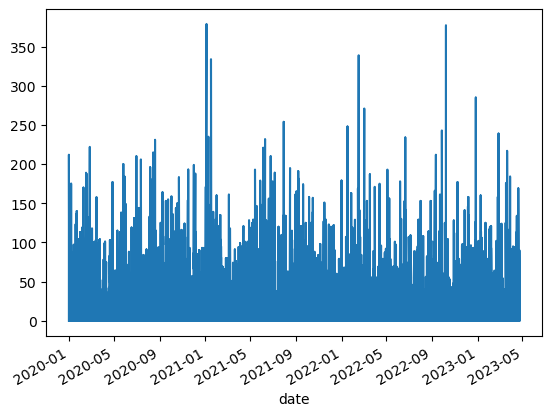

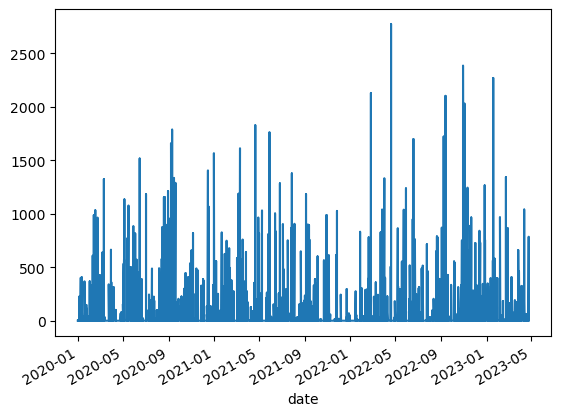

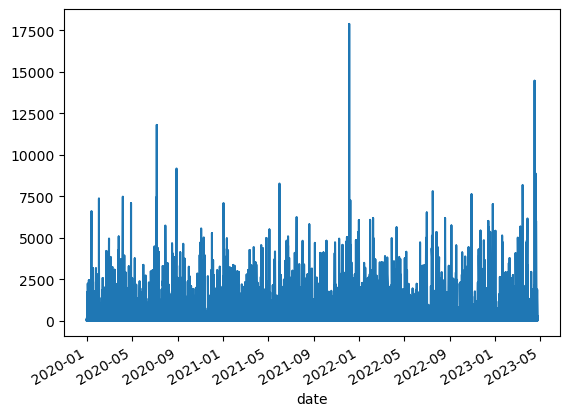

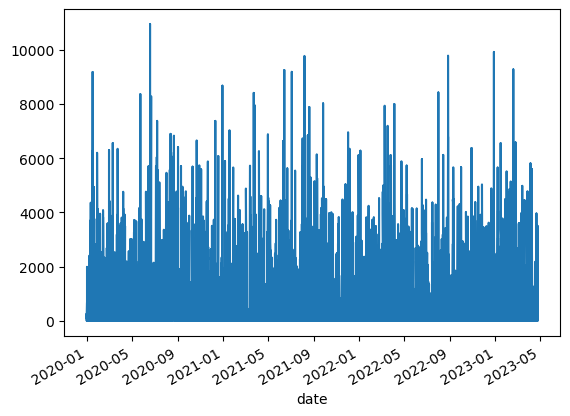

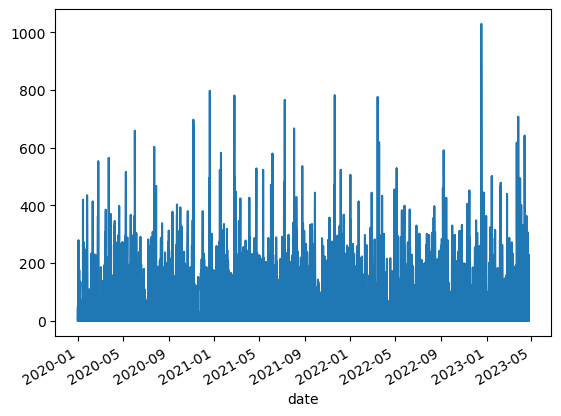

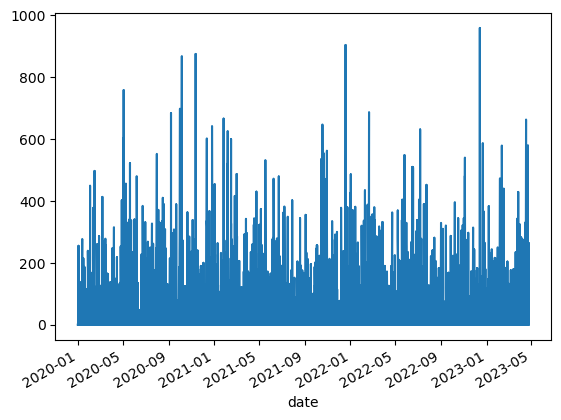

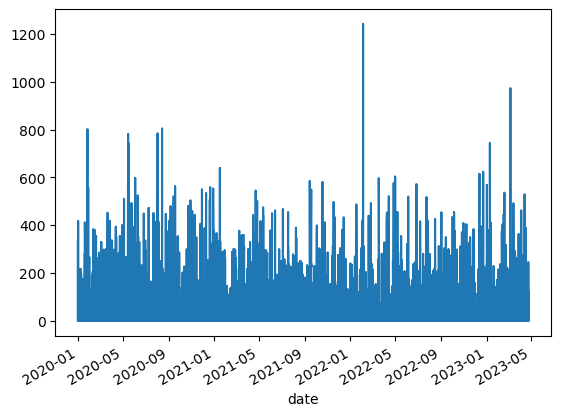

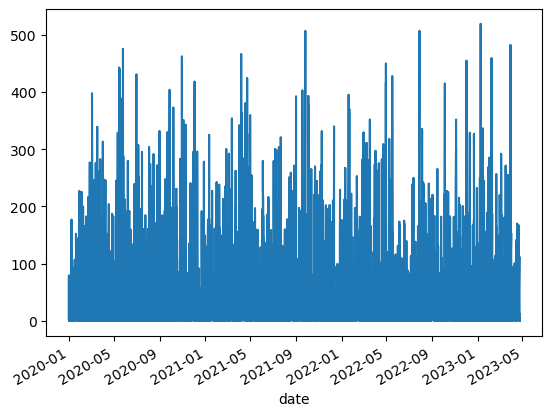

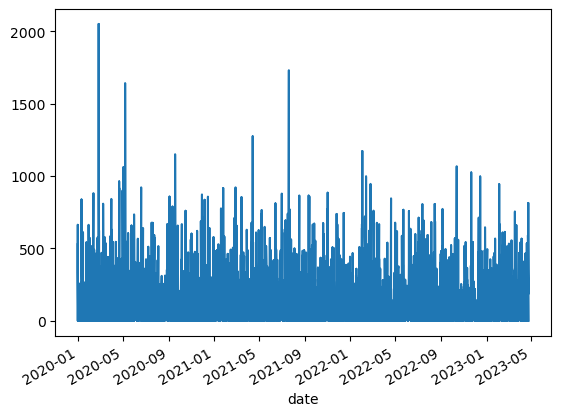

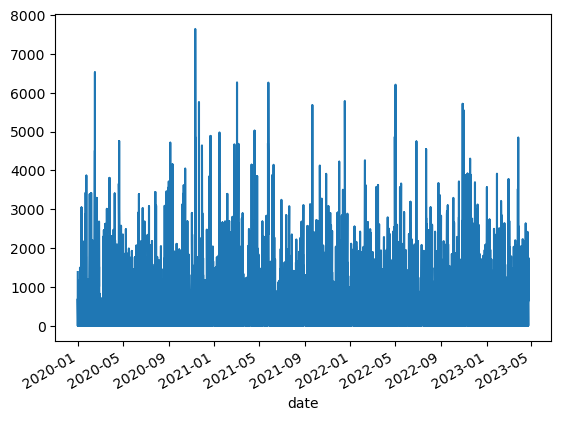

In [76]:
df = generate_sklearn_sales_data_v2(
    num_days=n_days,
    num_products=10,
    seed=42,
)
import matplotlib.pyplot as plt

for label, group in df.groupby("product_id"):
    group.set_index("date")["sales_qty"].plot()
    plt.show()

In [77]:
sklearnFakedata = pd.DataFrame()
sklearnFakedata = generate_sklearn_sales_data_v2(
    num_days=365 * 4,
    num_products=MAX_PRODUCTS,
    num_stores=20,
    seed=42,
)

sklearnFakedata.to_csv("sklearnFakeData_v2.csv", index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [78]:
len(sklearnFakedata)

2920000

In [79]:
{c: sklearnFakedata[c].nunique() for c in sklearnFakedata.columns}

{'date': 1460,
 'store_id': 20,
 'product_id': 100,
 'sales_qty': 12075,
 'price': 6053,
 'stock': 732,
 'discount': 22,
 'is_promo_day': 2,
 'color': 5,
 'size': 4,
 'category': 6,
 'subcategory': 6}